# Model Testset Performance Comparison

In [21]:
!pip3 install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [30]:
import sys, os
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

## Classifiers ##
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import model_type, AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Metrics ##
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, matthews_corrcoef, f1_score, accuracy_score, classification_report, precision_score, recall_score

## Utils: Font Size ##
from utils.fig_sizes import fig_sizes
from utils.sensitivity_specificity import plot_sensitivity_specificity

### Seed ###
random_state = 1234
np.random.seed(random_state)

## User Variables

In [23]:
## Folder paths ##
data_folder = '../Data/'
results_folder='../Results/'
models_folder='../Models/'
figures_folder ='../Figures/Performance/'

## Outcome variable ##
outcome_column='ckd_status'

## Load Data

In [24]:
### Load ###
train_data = pd.read_csv(data_folder+'train_data.csv')
test_data = pd.read_csv(data_folder+'test_data.csv')

### Feature list ###
feature_list = list()
for i in train_data.columns:
    if i[:2] == 'F_':
        feature_list.append(i)
        
### Setup Datasets ###
X_train = train_data[feature_list]
y_train = train_data[outcome_column]

X_test = test_data[feature_list]
y_test = test_data[outcome_column]

## Update Feature List ##
feature_list = list(X_test.columns)
print('Total Features: %s'%len(feature_list) )

/var/folders/65/qxp2fcwj00bff0rdg3hmhyx80000gn/T/ipykernel_65382/2835008153.py:2: DtypeWarning: Columns (30,41,42,66,67,68,69,83,87,103,104,105,121,122,123) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(data_folder+'train_data.csv')
/var/folders/65/qxp2fcwj00bff0rdg3hmhyx80000gn/T/ipykernel_65382/2835008153.py:3: DtypeWarning: Columns (30,41,42,66,67,68,69,83,87,103,104,105,121,122,123) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(data_folder+'test_data.csv')


Total Features: 128


## Models

### RandomForestClassifier: All Features

In [67]:
## Classifier ##
model_type='RandomForestClassifier'

## Load hyperparameters ##
with open(f'{models_folder}/Conventional/HPTuned_{model_type}.pkl', 'rb') as fh:
    Results_dict = pickle.load(fh)

# convert results dict values to ints
for key in Results_dict['hyperparameters']:
    Results_dict['hyperparameters'][key] = int(Results_dict['hyperparameters'][key])

print(Results_dict)

## Model ##
model = RandomForestClassifier(random_state=random_state)
model.set_params(**Results_dict['hyperparameters'])

## Train ##
print('Training')
model.fit(X=X_train, y=y_train)
## Test ##
print('Testing')
y_pred_rf = model.predict_proba(X_test)[:,1]

## Delete model ##
# del(model)

{'hyperparameters': {'n_estimators': 10000, 'n_jobs': -1}, 'aucroc': 0.9205310868909988}
Training
Testing


# Logistic Regression

In [70]:
## Classifier ##
model_type='LogisticRegression'

## Load hyperparameters ##
with open(f'{models_folder}/Conventional/HPTuned_{model_type}.pkl', 'rb') as fh:
    Results_dict = pickle.load(fh)

# convert results dict values to ints
for key in Results_dict['hyperparameters']:
    if type (Results_dict['hyperparameters'][key]) == float:
        Results_dict['hyperparameters'][key] = int(Results_dict['hyperparameters'][key])

print(Results_dict)

## Model ##
model = LogisticRegression(random_state=random_state)
model.set_params(**Results_dict['hyperparameters'])

## Train ##
print('Training')
model.fit(X=X_train, y=y_train)
## Test ##
print('Testing')
y_pred_rf = model.predict_proba(X_test)[:,1]

{'hyperparameters': {'max_iter': 1000000, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'saga'}, 'aucroc': 0.83346381498243}
Training
Testing


## Plot

### ROC

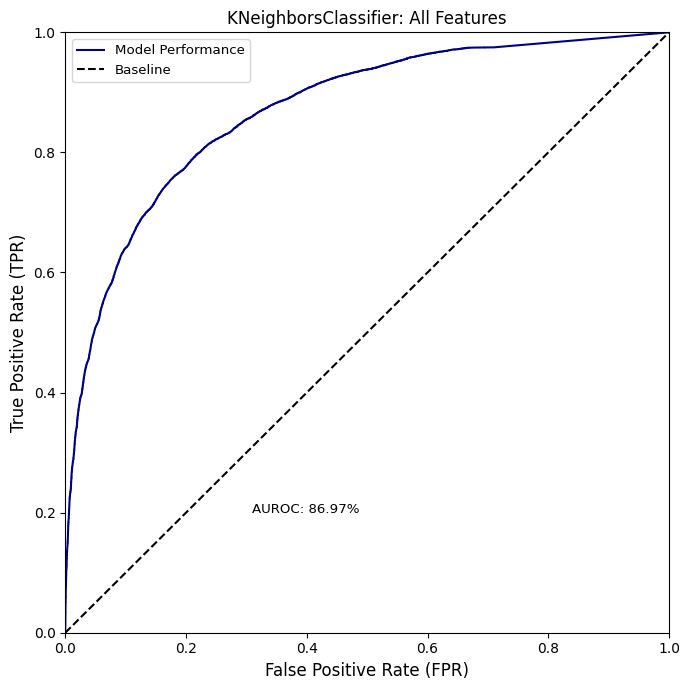

In [ ]:
## Plot ##
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf )
ax.plot(fpr,tpr, color='navy', label='Model Performance')
ax.plot([0,1],[0,1], color='black', linestyle='--', label='Baseline')
## Text: AUROC ##
ax.text(x=0.31 , y=0.20 , s=f'AUROC: {100*roc_auc_score(y_test, y_pred_rf ):0.2f}%',
             ha='left', fontsize=0.6*fig_sizes['labels'])
## Legend ##
ax.legend(fontsize=0.6*fig_sizes['labels']);
## Labels ##
ax.set_ylabel('True Positive Rate (TPR)', fontsize=0.6*fig_sizes['axis'])
ax.set_xlabel('False Positive Rate (FPR)', fontsize=0.6*fig_sizes['axis'])
ax.set_title(f'{model_type}: All Features', fontsize=0.6*fig_sizes['title'])
ax.set_xlim([0,1])
ax.set_ylim([0,1])

## Save Figure ##
plt.tight_layout()
plt.savefig(f'{figures_folder}/ROC_Curves.pdf')
plt.show()

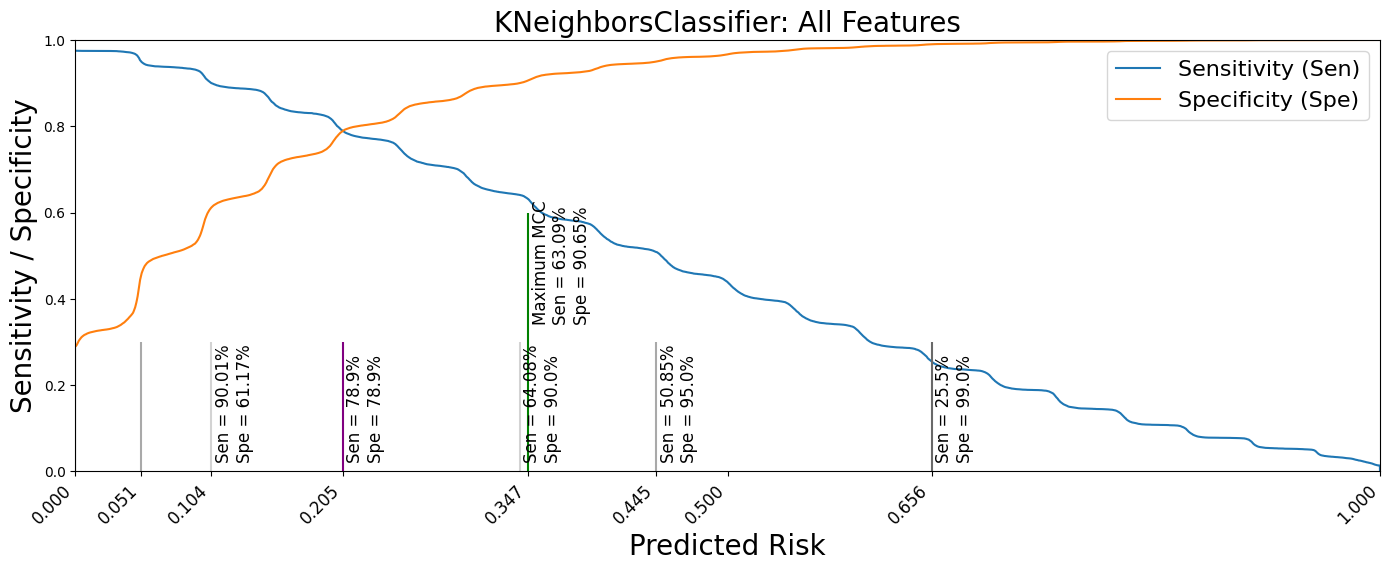

In [ ]:
plt.figure(figsize=(14,21))

plt.subplot(4,1,1)
plot_sensitivity_specificity(y_test, y_pred_rf, model_type=f'{model_type}', title=f'{model_type}: All Features')

plt.tight_layout()
plt.savefig(f'{figures_folder}/sensitivity_specificity_curves.pdf');
plt.show()

# Sensitivity Specificity / Confusion Matrix
- plot confusion matrix associated with highest MCC on test set

In [71]:
## Cleanup model names ##
model_name_map = {'LogisticRegression': 'Logistic Regression',
                  'RandomForestClassifier': 'Random Forest',
                  'AdaBoostClassifier': 'AdaBoost Classifier',
                  'GaussianNB': 'Gaussian NB',
                  'KNeighborsClassifier': 'KNN',
                  'SVC_radial': 'SVC',
                  'XGBoostClassifier': 'XGBoost',
                  'relu': 'NN: ReLu',
                  'softmax': 'NN: Softmax',
                  'sigmoid': 'NN: Sigmoid',
                  'gumbel_softmax': 'NN: Gumbel Softmax', }

performance_dict = {}

## Skip if Results Exist ##
if os.path.isfile(f'{models_folder}/Test_Performance.pkl'):
    performance_dict = pickle.load(
        open(f'{models_folder}/Test_Performance.pkl', 'rb'))

print(f'model_type: {model_type}')

## Dictionary keys ##
if model_type not in performance_dict:
    performance_dict[model_type] = {}

# Selecting the Dataset Subset ##:
X_train_subset = X_train
X_test_subset = X_test

## Check that features do not contain outcome variable ##
assert outcome_column not in X_train_subset.columns
assert outcome_column not in X_test_subset.columns

## Update Feature List ##
feature_list = list(X_test_subset.columns)

# model already defined above

## Find best threshold for prediction binarization (on Training dataset) ##
print('\tPredict ', end='\r')
y_pred = model.predict_proba(X_train_subset)[:, 1]
print(f'\tThresholding...', end='\r')
mcc_list = [matthews_corrcoef(
    y_true=y_train, y_pred=y_pred > thresh) for thresh in thresholds]
best_thresh = thresholds[np.where(mcc_list == np.max(mcc_list))[0]][0]
print(f'Best Threshold: {best_thresh}       ')

## Test ##
print('\tTesting ', end='\r')
y_pred = model.predict_proba(X_test_subset)[:, 1]
y_pred_bin = y_pred > best_thresh
performance_dict[model_type]['y_pred'] = y_pred

## Performance ##
performance_dict[model_type]['threshold'] = best_thresh
performance_dict[model_type]['AUROC'] = roc_auc_score(
    y_true=y_test, y_score=y_pred)
performance_dict[model_type]['MCC'] = matthews_corrcoef(
    y_true=y_test, y_pred=y_pred_bin)
performance_dict[model_type]['F1'] = f1_score(
    y_true=y_test, y_pred=y_pred_bin)
performance_dict[model_type]['accuracy'] = accuracy_score(
    y_true=y_test, y_pred=y_pred_bin)
performance_dict[model_type]['recall'] = recall_score(
    y_true=y_test, y_pred=y_pred_bin)
performance_dict[model_type]['precision'] = precision_score(
    y_true=y_test, y_pred=y_pred_bin)

## Save Performance Dictionary ##
with open(f'{models_folder}/Test_Performance.pkl', 'wb') as fh:
    pickle.dump(performance_dict, fh)

print('Done')


model_type: LogisticRegression
Best Threshold: 0.384       
Doneting 


Text(0.5, 1.0, 'LogisticRegression: All Features')

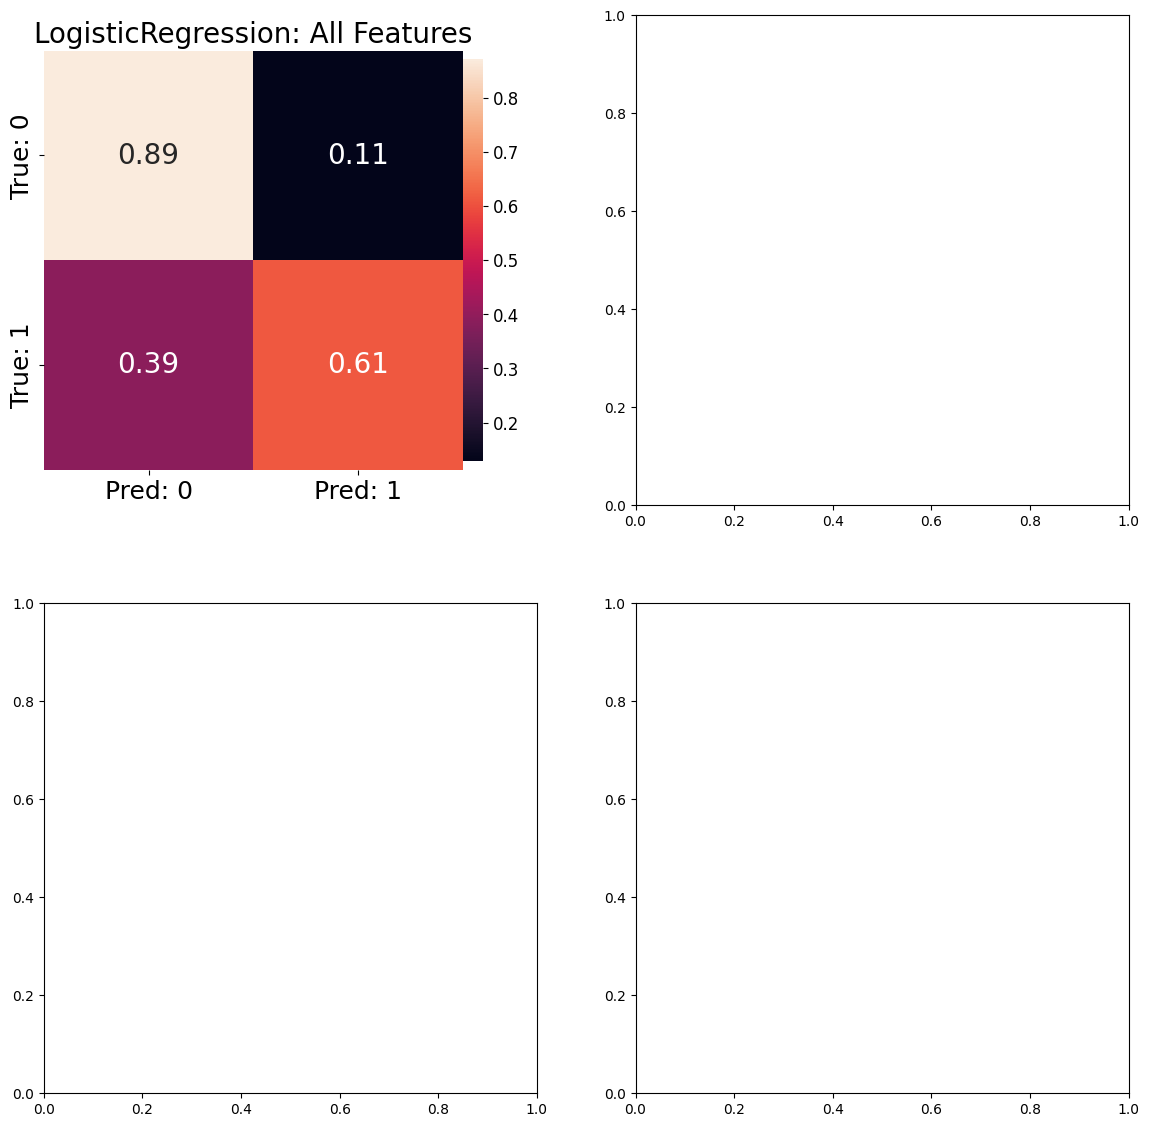

In [72]:
## Plot ##
fig, ax = plt.subplots(2, 2, figsize=(14, 14))
## Prediction Binarization thresholds to test ##
thresholds = np.arange(0, 1, 1E-3)

### RandomForest: All Features ###
title = f'{model_type}: All Features'
threshold = performance_dict[f'{model_type}']['threshold']
predictions = performance_dict[f'{model_type}']['y_pred'] > threshold
ax_current = ax[0, 0]

confusion_matrix_data = confusion_matrix(
    y_true=y_test, y_pred=predictions, normalize='true')
## heatmap ##
hmap = sns.heatmap(confusion_matrix_data, annot=True, square=True,
                   xticklabels=['Pred: 0', 'Pred: 1'],
                   yticklabels=['True: 0', 'True: 1'],
                   robust=True,
                   annot_kws={'fontsize': 20},
                   cbar_kws={'pad': 0, 'shrink': 0.82},
                   ax=ax_current
                   )
## Axis label size ##
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize=18)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize=18)
## Colorbar fontsize ##
hmap.collections[0].colorbar.ax.tick_params(labelsize=12)
## Title ##
ax_current.set_title(title, fontsize=20)
